>### 🚩 *Create a free WhyLabs account to get more value out of whylogs!*<br> 
>*Did you know you can store, visualize, and monitor whylogs profiles with the [WhyLabs Observability Platform](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Performance_Estimation)? Sign up for a [free WhyLabs account](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Performance_Estimation) to leverage the power of whylogs and WhyLabs together!*

# Performance Estimation - Estimating Accuracy for Binary Classification Problems

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whylabs/whylogs/blob/mainline/python/examples/experimental/performance_estimation.ipynb)

Once your model is deployed, monitoring its performance plays a crucial role in ensuring the quality of your ML system. To calculate metrics such as accuracy, labels are required. However, in many cases, labels can be unavailable, partially available or come in a delayed fashion.

In this notebook, we will show one possible way of estimating the performance of your model without having access to the labels. We will use the [Ecommerce dataset](https://whylogs.readthedocs.io/en/latest/datasets/ecommerce.html) to demonstrate the process.

We will cover:

- [Importance Weighting for Accuracy Estimation - Rationale](#rationale)
- [The scenario - Covariate Shift with the Ecommerce Dataset](#scenario)
- [Using whylogs to estimate accuracy](#whylogs)
- [Uploading the results to WhyLabs](#whylabs)
- [Conclusion](#conclusion)

First, let's define the scope of this example:

We are concerned with estimating the __accuracy__ of a __binary classification model__ for an __unlabeled target__ dataset. We will do so by leveraging a __labeled reference__, or baseline, dataset.

## Importance Weighting for Accuracy Estimation <a class="anchor" id="rationale"></a>

As previously stated, the challenge is to estimate the accuracy of a model without having access to the labels.

One way to do so is to use a labeled reference dataset. This can be your test set, or a subset of it. We can then identify ways to segment both the reference and the target datasets. For example, we might segment a dataset according to age, profession, or location. We can then calculate the reference dataset's accuracy for each segment. To finally estimate the overall accuracy of the target dataset, we can use the reference dataset's accuracy as a proxy, and weight it according to the proportion of the target dataset's segments.

Let's see how this works in practice.

### Reference Dataset

Assume we have a reference dataset for which we have labels. We then segment this dataset into 4 different categories: A, B, C, and D. Since we have the labels, we can then calculate the accuracy of each segment. If the chosen segments are mutually exclusive and exhaustive, we can also calculate the reference dataset's overall accuracy by simply weighting the accuracy of each segment by its proportion in the reference dataset. So, if we have the following accuracies and proportions:

> Mutually exclusive and exhaustive segments means that our segments don't overlap with each other, and the sum of the segments equal to the complete dataset.

__Reference Dataset__

| Segment | Accuracy | Proportion |
|:-------:|:--------:|:----------:|
|    A    |   0.92   |     32%    |
|    B    |   0.56   |     27%    |
|    C    |   0.67   |     16%    |
|    D    |   0.75   |     25%    |

The overall accuracy of the reference dataset is:

$Acc_{ref} = p_{A}*Acc_{A} + p_{B}*Acc_{B} + p_{C}*Acc_{C} + p_{D}*Acc_{D} $

$Acc_{ref} = 0.32*0.92 + 0.27*0.56 + 0.16*0.67 + 0.25*0.75 = 0.74 $

### Target Dataset

Great! So, how do we use this information to estimate the accuracy of our target dataset?


Suppose we have the following information about our target dataset:

__Target Dataset__

| Segment | Accuracy | Proportion |
|:-------:|:--------:|:----------:|
|    A    |     ?    |     16%    |
|    B    |     ?    |     67%    |
|    C    |     ?    |     6%     |
|    D    |     ?    |     11%    |

We can see that the proportions for each segment are different from the reference dataset, with a significant increase in the proportion of data belonging to segment B. We don't have the accuracy for each segment, and we want to estimate the overall accuracy of the target dataset. The intuition is that we can use the reference dataset's accuracy for each segment as a proxy, and weight those accuracies by the proportion of each segment in the target dataset. This will give us an estimate of the overall accuracy of the target dataset.

So, if we denote $\overline{Acc}_{target}$ as the estimated overall accuracy of the target dataset, we can calculate it as follows:

$\overline{Acc}_{target} = p_{A}*Acc_{ref_A} + p_{B}*Acc_{ref_B} + p_{C}*Acc_{ref_C} + p_{D}*Acc_{ref_D} $

$\overline{Acc}_{target} = 0.16*0.92 + 0.67*0.56 + 0.06*0.67 + 0.11*0.75 = 0.645$

Where $Acc_{ref_A}$, $Acc_{ref_B}$, $Acc_{ref_C}$, and $Acc_{ref_D}$ are the accuracies of the reference dataset for each segment.

### Considerations

In the example above, we're considering that the main reason for the difference in performance between the reference and target datasets is due to a change in the distribution of the input data. This is known as __covariate shift__.

That said, there are other reasons why the performance of a model can change, such as (but not limited to):

- __Concept drift__: The relationship between the input data and the target variable changes. This is known as __concept drift__.
- __Covariate shift to unknown regions of the feature space__: Suppose our model was trained of a demographic with age 15-70. If during production we receive data from a demographic with age 0-14 or above 70, the model's performance will likely decrease.
- __Data quality issues__: Missing values, outliers, data schema changes, etc. can affect the performance of a model.

For all of above examples, it is possible that the importance weighting approach presented here will not yield accurate estimates.

Another important consideration is the importance of choosing the proper segments to perform the importance weighting. The segments in the target dataset must be a subset of the reference dataset, as an unseen segment will not have an associated accuracy. The segments also should ideally have high variance in training accuracies: if all segments have the same accuracy, then weighting them would not make much sense. Additionally, as stated previously, in this example we are assuming that the segments are mutually exclusive and exhaustive.

## The Scenario <a class="anchor" id="scenario"></a>

Let's see how this approach works in practice with the [Ecommerce dataset](https://whylogs.readthedocs.io/en/latest/datasets/ecommerce.html).

This dataset contrains transactions made by customers of an online store. The goal is to predict whether a product should be given a discount or not, based on the product's category, market price, product rating and sales history. It is a binary classification task, as the `output_discount` column contains a `1` if the product should be given a discount, and a `0` otherwise.

We will segment the dataset according to the `category` column. This column contains 11 different categories such as `Beverages`, `Vegetables` or `Baby Care`.

We want to simulate a scenario where the distribution of the input data changes, leading to changes in the model's performance. To do so, we will get data for 7 different days, and "perturb" the data for each day: we will pick 4 different categories for each day, and randomly subsample each category between a range of 10%-30%: that is, we will end up with 10 to 30% of the original segment size for each subsampled category.

For the reference dataset, we will use the dataset that was originally used to test the model in an experimental (pre-deployment) stage.

In this example, we actually have the labels for the perturbed days. We'll end the example with the plot showing the estimated accuracy vs. the real accuracy for each day.

## Accuracy Estimation with whylogs <a class="anchor" id="whylogs"></a>

Let's finally see how we can use whylogs to estimate the accuracy of a model.

first, let's install whylogs and the required extras:

In [ ]:
# Note: you may need to restart the kernel to use updated packages.
%pip install 'whylogs[whylabs,datasets]'

### Getting the Reference and Target Datasets

The first thing we need is to get:

- Reference dataset
- 7  daily "perturbed" target datasets

This dataset is already in the whylogs' `datasets` module, so we'll source it from there. We'll then arrange the data into a more proper format, and then create a function to perturb each day by random subsampling a subset of our categories.

In [1]:
from whylogs.datasets import Ecommerce

dataset = Ecommerce()

baseline = dataset.get_baseline()

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None # default='warn’

def arrange_df(batch):
    df = batch.features
    df['output_discount'] = batch.target['output_discount']
    df['output_prediction'] = batch.prediction['output_prediction']
    return df

reference_df = arrange_df(baseline)
reference_df.head()

,product,sales_last_week,market_price,rating,category,output_discount,output_prediction
date,,,,,,,
2023-02-28 00:00:00+00:00,Wood - Centre Filled Bar Infused With Dark Mou...,1,350.0,4.500000,Snacks and Branded Foods,0,1
2023-02-28 00:00:00+00:00,Toasted Almonds,1,399.0,3.944479,Gourmet and World Food,1,0
2023-02-28 00:00:00+00:00,Instant Thai Noodles - Hot & Spicy Tomyum,1,95.0,3.300000,Gourmet and World Food,0,0
2023-02-28 00:00:00+00:00,Thokku - Vathakozhambu,1,336.0,4.300000,Snacks and Branded Foods,0,1
2023-02-28 00:00:00+00:00,Beetroot Powder,1,150.0,3.944479,Gourmet and World Food,0,0


Those are the categories that will be randomly subsampled for each day:

In [3]:
perturbations_by_day = {
    0 : ['Kitchen, Garden and Pets','Beauty and Hygiene', 'Fruits and Vegetables','Bakery, Cakes and Dairy'],
    1 : ['Snacks and Branded Foods','Beverages', 'Baby Care', 'Gourmet and World Food'],
    2 : ['Beauty and Hygiene','Kitchen, Garden and Pets', 'Bakery, Cakes and Dairy','Fruits and Vegetables'],
    3 : ['Foodgrains, Oil and Masala','Cleaning and Household','Eggs, Meat and Fish','Bakery, Cakes and Dairy'],
    4 : ['Cleaning and Household','Gourmet and World Food','Kitchen, Garden and Pets','Beauty and Hygiene'],
    5 : ['Baby Care','Bakery, Cakes and Dairy','Kitchen, Garden and Pets'],
    6 : ['Beverages', 'Eggs, Meat and Fish', 'Foodgrains, Oil and Masala'],

    }

And the following function will be used to perturb the data:

In [4]:
import numpy as np


def random_subsample_on_column(df, column, lower_pct=0.1 , upper_pct=0.3, classes = 'all'):
    """Subsample each class in a column to a random percentage of the total.

    The percentage is sampled uniformly between lower_pct and upper_pct.
    If classes is not 'all', then only subsample the classes in classes.

    Args:
        df (pd.DataFrame): The dataframe to subsample.
        column (str): The column to subsample on.
        lower_pct (float): The lower bound of the percentage to subsample.
        upper_pct (float): The upper bound of the percentage to subsample.
        classes (list): The classes to subsample. If 'all', then subsample all classes.

    """
    if classes == 'all':
        class_names = df[column].unique()
    elif isinstance(classes, list):
        assert all([c in df[column].unique() for c in classes]), "Classes must be in the column"
        class_names = classes
    for c in class_names:
        sub_df = df.loc[df[column]==c]
        n = int(len(sub_df) * (lower_pct + (upper_pct - lower_pct) * np.random.random()))
        # remove n rows from the class
        df = df.loc[df[column] != c].append(sub_df.sample(n=n))
    return df

Let's get our perturbed dfs: 

In [5]:
batches = dataset.get_inference_data(number_batches=7)

perturbed_dfs = []
for day, batch in enumerate(batches):
    unperturbed_df = arrange_df(batch)
    perturbed_df = random_subsample_on_column(unperturbed_df, 'category', lower_pct=0.1, upper_pct=0.3, classes = perturbations_by_day[day])
    perturbed_dfs.append(perturbed_df)

### whylogs Profiling

We'll start by profiling the reference dataset, and then the target datasets. We'll use the `category` column as the segment column, and we'll use the `output_discount` column as the target column.


For each profiling process, we'll end up with 11 different whylogs profiles - one for each category. Those 11 profiles will be encapsulated in a `SegmentedResultSet`. Those sets are what we'll use to perform the accuracy estimation.


In [6]:
import whylogs as why
from whylogs.core.segmentation_partition import segment_on_column
from whylogs.core.schema import DatasetSchema

def log_dataset(df, labeled=True):
    segment_column = "category"
    segmented_schema = DatasetSchema(segments=segment_on_column(segment_column))
    
    # Just to be sure that we're not using actual labels/metrics for the target dataset.
    if labeled:
        results = why.log_classification_metrics(
            df,
            target_column = "output_discount",
            prediction_column = "output_prediction",
            schema=segmented_schema,
            log_full_data=True
        )
        return results
    else:
        results = why.log(df, schema=segmented_schema)
        return results

reference_results = log_dataset(reference_df, labeled=True)
perturbed_results_list = [log_dataset(perturbed_df, labeled=False) for perturbed_df in perturbed_dfs]

Note that for the reference data we're logging by calling `why.log_classification_metrics`, which will give us access to the performance metrics. As for the target data, since we don't have labels, we're logging by calling `why.log`, which will give us access to the counts for each segment.

### Estimating accuracy with the `performance_estimation` module

Once we have the Result Sets available for reference and target datasets, we can use the `AcccuracyEstimator` from the `performance_estimation` module to estimate the accuracy of the target dataset.

Let's do it for the first day to demonstrate:

In [8]:
from whylogs.experimental.performance_estimation.estimators import AccuracyEstimator

estimator = AccuracyEstimator(reference_result_set = reference_results)

first_day_result = perturbed_results_list[0]
estimation_result = estimator.estimate(first_day_result)

print(f"Day 0 accuracy - estimated: {estimation_result.accuracy}")

Day 0 accuracy - estimated: 0.6387135902595148


When initializing the estimator, we pass our reference result set. It will leverage the performance metrics for each segment's profiles to perform the accuracy estimation.

When asked for an estimation for the target dataset, it will weight the reference result accuracies by the proportion of each segment in the target dataset, and return the estimated accuracy.

Is this a good estimate? Let's see how it compares to the real accuracy.

### Plotting the estimated accuracy vs. the real accuracy


To plot the accuracies for the 7 days, let's define the different types of accuracies in the plot:

- Real accuracy: The real accuracy for the perturbed data. This would only be available if we had all the labels, which is the problem we're trying to solve.
- Estimated accuracy: The accuracy estimated by the `AccuracyEstimator`.
- Pre-deployment accuracy: If we didn't have the labels, nor did any kind of estimation, our best guess would be to assume the model's performance is the same as it was during the pre-deployment stage. This is the accuracy we would use if we didn't have any other information.

Let's first get a list for all 3 different types of accuracies for each day. Then we'll plot them in a line chart.


In [8]:
from whylogs.experimental.performance_estimation import AccuracyEstimator
import pandas as pd

pd.options.mode.chained_assignment = None # default='warn’


def calculate_real_accuracy(df):
    metrics_df = df[['output_discount','output_prediction']]
    correct = 0
    incorrect = 0
    for index,row in metrics_df.iterrows():
        
        if row['output_discount'] == row['output_prediction']:
            correct += 1
        else:
            incorrect += 1
    acc = correct/(correct+incorrect)
    return acc


estimator = AccuracyEstimator(reference_result_set = reference_results)

pre_deployment_accs = []
real_accs = []
estimated_accs = []
for day, perturbed in enumerate(zip(perturbed_results_list, perturbed_dfs)):
    perturbed_results = perturbed[0]
    perturbed_df = perturbed[1]

    real_acc = calculate_real_accuracy(perturbed_df)
    pre_deployment_acc = calculate_real_accuracy(reference_df)
    estimation_result = estimator.estimate(perturbed_results)
    estimated_acc = estimation_result.accuracy

    pre_deployment_accs.append(pre_deployment_acc)
    real_accs.append(real_acc)
    estimated_accs.append(estimated_acc)
    print(f"Day {day} accuracy - real: {real_acc}, estimated: {estimated_acc}, pre-deploy: {pre_deployment_acc}")

Day 0 accuracy - real: 0.644542772861357, estimated: 0.6449857773314478, pre-deploy: 0.6741501885271853
Day 1 accuracy - real: 0.6866051543111676, estimated: 0.6919219880068938, pre-deploy: 0.6741501885271853
Day 2 accuracy - real: 0.6291828793774319, estimated: 0.6398225939212645, pre-deploy: 0.6741501885271853
Day 3 accuracy - real: 0.6890386869871044, estimated: 0.684898937625555, pre-deploy: 0.6741501885271853
Day 4 accuracy - real: 0.6733477789815818, estimated: 0.6626462398863927, pre-deploy: 0.6741501885271853
Day 5 accuracy - real: 0.665058189043429, estimated: 0.6551432545163998, pre-deploy: 0.6741501885271853
Day 6 accuracy - real: 0.6886766712141883, estimated: 0.6867237421366811, pre-deploy: 0.6741501885271853


Now we  can plot the accuracies for each day:

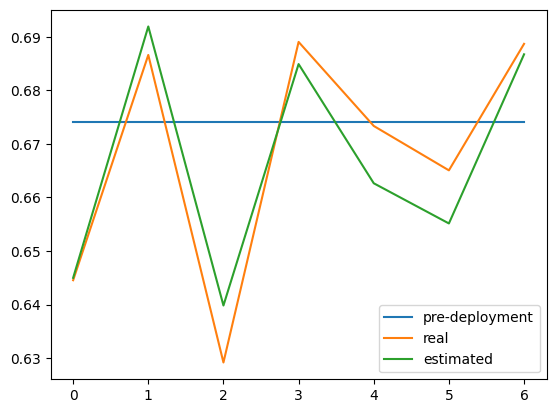

Estimated MSE: 5.36355459317329e-05, Pre-deployment MSE: 0.0005099683612281597


In [9]:
import matplotlib.pyplot as plt
# plot pre-deployment, real and estimated accuracy
plt.plot(pre_deployment_accs, label='pre-deployment')
plt.plot(real_accs, label='real')
plt.plot(estimated_accs, label='estimated')
plt.legend()
plt.show()

mse = np.mean((np.array(real_accs) - np.array(estimated_accs))**2)
baseline_mse = np.mean((np.array(real_accs) - np.array(pre_deployment_accs))**2) 

print(f"Estimated MSE: {mse}, Pre-deployment MSE: {baseline_mse}")	

The __Estimated MSE__ is the mean squared error between Estimated and Real accuracies, while the __Pre-deployment MSE__ is the mean squared error between Pre-deployment and Real accuracies.

As we can see, even though the estimates are not perfect, it is very closer to the real ones than if we had used the pre-deployment accuracy. The seeds are not fixed in this example, so you can rerun to see different results. I find that the errors for the estimated accuracies are usually roughly one order of magnitude smaller than the errors for the pre-deployment accuracies. This is a sign that the accuracy estimation is working well.

## Uploading the results to WhyLabs <a class="anchor" id="whylabs"></a>

Let's see how to have the estimated accuracy available in your WhyLabs dashboard.

First, let's set our WhyLabs environment variables:

In [ ]:
import getpass
import os

# set your org-id here - should be something like "org-xxxx"
print("Enter your WhyLabs Org ID") 
os.environ["WHYLABS_DEFAULT_ORG_ID"] = input()

# set your datased_id (or model_id) here - should be something like "model-xxxx"
print("Enter your WhyLabs Dataset ID")
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = input()


# set your API key here
print("Enter your WhyLabs API key")
os.environ["WHYLABS_API_KEY"] = getpass.getpass()
print("Using API Key ID: ", os.environ["WHYLABS_API_KEY"][0:10])

Now, let's iterate through the days again. The difference this time is we'll write both the result set and estimated result  to WhyLabs.

Just be sure to set the result set's timestamp before performing the estimation, so that the estimated result will have the same timestamp as the result set.


In [14]:
from datetime import datetime, timedelta, timezone
from whylogs.experimental.performance_estimation import AccuracyEstimator
from whylogs.api.writer.whylabs import WhyLabsWriter
import whylogs as why

writer = WhyLabsWriter()
estimator = AccuracyEstimator(reference_result_set = reference_results)

for day, perturbed in enumerate(zip(perturbed_results_list, perturbed_dfs)):
    dataset_timestamp = datetime.now() - timedelta(days=day)
    dataset_timestamp = dataset_timestamp.replace(tzinfo = timezone.utc)
    perturbed_results = perturbed[0]

    perturbed_results.set_dataset_timestamp(dataset_timestamp)

    #logging the data
    perturbed_results.writer("whylabs").write()
    estimator.estimate(perturbed_results).writer("whylabs").write()


You will find the estimated accuracy in the `Outputs` tab of your WhyLabs dashboard. Since we're logging a single row for each day, the `estimated median` graph will show the estimated accuracy for each day:

![alt text](images/accuracy_estimation.png)


> The PerformanceEstimator is still an experimental feature, and the WhyLabs support for it is still under development. It is likely that both whylogs and WhyLabs will evolve to better support the performace estimation use case.

## Conclusion <a class="anchor" id="conclusion"></a>

In this example, we showed how we can use whylogs to estimate the accuracy of a model when the distribution of the input data changes, and when we don't have available labels to calculate the real accuracy. We used the `AccuracyEstimator` from the `performance_estimation` module to estimate the accuracy of a model, and we compared the estimated accuracy to the real accuracy. However, even when we do have the labels, or a subset of them, it can still be useful to draw estimates to help further debug and analyse the root cause of eventual changes in performance.

It's also important to note the approach's limitations and assumptions, with regards to the root cause of changes in the performance and the importance of properly choosing the segments to perform the importance weighting.

The estimator is still in beta and we are always working on improving it. We'd love to hear your feedback!

## References

- [Shankar, Shreya, and Aditya Parameswaran. "Towards Observability for Production Machine Learning Pipelines."](https://arxiv.org/pdf/2108.13557.pdf)
- [Oreilly event - Monitor Real-Time Machine Learning Performance](https://learning.oreilly.com/live-events/monitor-real-time-machine-learning-performance/0636920075104/0636920075102/)
- [whylogs - Ecommerce dataset](https://whylogs.readthedocs.io/en/latest/datasets/ecommerce.html)